In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from import_lib.func import sphere, weierstrass, ackley, rosenbrock, schwefel, griewank, rastrigin
from import_lib.GA import population_init, factorial_cost, factorial_rank, skill_factor_best_task, polynomial_mutation, sbx_crossover

In [2]:
'''
CEC'17
'''
tasks = [
    sphere(     50,shift= 0,    limited_space= True, lower_bound= -100, upper_bound= 100),   # 0
    sphere(     50,shift= 80,   limited_space= True, lower_bound= -100, upper_bound= 100),  # 80
    sphere(     50,shift= -80,  limited_space= True, lower_bound= -100, upper_bound= 100), # -80
    weierstrass(25,shift= -0.4, limited_space= True, lower_bound= -0.5, upper_bound= 0.5), # -0.4
    rosenbrock( 50,shift= -1,   limited_space= True, lower_bound= -50, upper_bound= 50),# 0
    ackley(     50,shift= 40,   limited_space= True, lower_bound= -50, upper_bound= 50),    # 40
    weierstrass(50,shift= -0.4, limited_space= True, lower_bound= -0.5, upper_bound= 0.5), # -0.4
    schwefel(   50,shift= 0,    limited_space= True, lower_bound= -500, upper_bound= 500), # 420.9687
    griewank(   50,shift= [-80, 80],limited_space= True, lower_bound= -100, upper_bound= 100), # -80, 80
    rastrigin(  50,shift= [-40, 40],limited_space= True, lower_bound= -50, upper_bound= 50),# -40, 40
]

In [3]:
print(tasks[0].func(tasks[0].encode(np.array([0] * 50))))
print(tasks[1].func(tasks[1].encode(np.array([80] * 50))))
print(tasks[2].func(tasks[2].encode(np.array([-80] * 50))))
print(tasks[3].func(tasks[3].encode(np.array([-0.4] * 25))))
print(tasks[4].func(tasks[4].encode(np.array([0] * 50))))
print(tasks[5].func(tasks[5].encode(np.array([40] * 50))))
print(tasks[6].func(tasks[6].encode(np.array([-0.4] * 50))))
print(tasks[7].func(tasks[7].encode(np.array([420.9687] * 50))))
print(tasks[8].func(tasks[8].encode(np.append(np.array([-80] * 25), np.array([80] * 25)))))
print(tasks[9].func(tasks[9].encode(np.append(np.array([-40] * 25), np.array([40] * 25)))))


0.0
0.0
0.0
0.0
0.0
4.440892098500626e-16
0.0
0.0006363918728311546
0.0
0.0


In [4]:
print(tasks[0].encode(np.array([0] * 50))[[0, -1]])
print(tasks[1].encode(np.array([80] * 50))[[0, -1]])
print(tasks[2].encode(np.array([-80] * 50))[[0, -1]])
print(tasks[3].encode(np.array([-0.4] * 25))[[0, -1]])
print(tasks[4].encode(np.array([0] * 50))[[0, -1]])
print(tasks[5].encode(np.array([40] * 50))[[0, -1]])
print(tasks[6].encode(np.array([-0.4] * 50))[[0, -1]])
print(tasks[7].encode(np.array([420.9687] * 50))[[0, -1]])
print(tasks[8].encode(np.append(np.array([-80] * 25), np.array([80] * 25)))[[0, -1]])
print(tasks[9].encode(np.append(np.array([-40] * 25), np.array([40] * 25)))[[0, -1]])

[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.51 0.51]
[0.5 0.5]
[0.5 0.5]
[0.9209687 0.9209687]
[0.5 0.5]
[0.5 0.5]


In [5]:
def Success_History_Memory_Update(M, next_update_position_M, S, delta, K):

    for i in range(K):
        for j in range(K):
            if len(S[i][j]) != 0:
                M[i, j][next_update_position_M[i, j]] =\
                    np.sum(np.array(delta[i][j]) * np.array(S[i][j])**2)/np.sum(np.array(delta[i][j]) * (np.array(S[i][j]))+ 1e-10)
                
                next_update_position_M[i, j] = (next_update_position_M[i, j] + 1) % M.shape[2]

    return M, next_update_position_M

In [6]:
pos = 5 - 1
if pos == -1: pos = 50
np.arange(50 - 1, -1, -1)[np.arange(50) - 51 + 1]

array([49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33,
       32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16,
       15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [7]:
def cus_MFEA(num_epochs, num_inds_each_task, nc = 15, nm = 15, mutation_all_gen:bool = False, tasks = [],
            sigmoid = 0.1, H = 30, get_neg_Delta = False,
            one_line = False, num_epochs_printed = 20 ):
    #save history of factorial cost
    history_cost = np.empty((0, len(tasks)), np.float)
    
    max_d = 0
    for t in tasks:
        if max_d < t.d:
            max_d = t.d

    # initial population and skill_factor_arr
    population, skill_factor_arr = population_init(
        N = num_inds_each_task, 
        num_tasks = len(tasks), 
        d = max_d,
    )
    
    # get skill_factor for pop
    skill_factor_arr = skill_factor_best_task(population, tasks)
    population_factorial_cost = factorial_cost(population, skill_factor_arr, tasks)


    history_cost = np.append(history_cost, [[np.min(population_factorial_cost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], axis = 0)

    #Inittialize success history mem M
    M = np.ones((len(tasks), len(tasks), H)) / 2
    next_update_position_M = np.zeros((len(tasks), len(tasks)), dtype= np.int)

    # mean and sd of rmp each generations
    # len(task) * len(tasks) * generations * 2
    saved_rmp = np.array([[[[0.5, 0]]]* len(tasks)] * len(tasks)).tolist()
    
    for epoch in range(num_epochs):

        S = np.empty((len(tasks), len(tasks), 0)).tolist()
        delta = np.empty((len(tasks), len(tasks), 0)).tolist()

        #initial offspring for epoch
        offspring = np.empty((0, max_d))
        offspring_skill_factor = np.empty((0, ), np.int)
        offspring_factorial_cost = np.empty((0, ), np.int)

        # his rmp of this generation
        rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

        while len(offspring) < len(population):
            skf_pa, skf_pb = np.random.choice(np.arange(len(tasks)), size = 2, replace= False)          

            gamma = 0.9
            pos = next_update_position_M[skf_pa, skf_pb] - 1
            if pos == -1: pos = H
            mu = np.sum(M[skf_pa, skf_pb] * 
                        gamma ** np.arange(H - 1, -1, -1)[np.arange(H) - pos]
            ) / np.sum(gamma ** np.arange(H - 1, -1, -1)[np.arange(H) - pos])
            rmp = np.random.normal(mu, sigmoid)
            if rmp < 0: rmp = 0
            if rmp > 1: rmp = 1

            # save generation's rmp
            rmp_this_gen[skf_pa][skf_pb].append(rmp)

            # Inter-task crossover
            if np.random.uniform() <= rmp*(len(tasks) - 1)/len(tasks):
                idx_pa = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
                idx_pb = np.random.choice(np.where(skill_factor_arr == skf_pb)[0])
                pa, pb = population[idx_pa], population[idx_pb]

                oa, ob = sbx_crossover(pa, pb, nc)
                skf_oa, skf_ob = skf_pa, skf_pa
            # Intra-task
            else:
                idx_pa = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
                idx_pb = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
                pa, pb = population[idx_pa], population[idx_pb]

                oa, ob = sbx_crossover(pa, pb)
                skf_oa, skf_ob = skf_pa, skf_pa

            # mutation
            oa = polynomial_mutation(oa,nm, mutation_all_gen)
            ob = polynomial_mutation(ob,nm, mutation_all_gen)   
            fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)

            Delta = max(0, 
                    (population_factorial_cost[idx_pa] - fcost_oa)/population_factorial_cost[idx_pa],
                    (population_factorial_cost[idx_pa] - fcost_ob)/population_factorial_cost[idx_pa]
                )

            if Delta > 0:
                S[skf_pa][skf_pb].append(rmp)
                delta[skf_pa][skf_pb].append(Delta)    

            if get_neg_Delta and Delta == 0:
                Delta = min(0, 
                    (population_factorial_cost[idx_pa] - fcost_oa)/population_factorial_cost[idx_pa],
                    (population_factorial_cost[idx_pa] - fcost_ob)/population_factorial_cost[idx_pa]
                )
                if Delta < 0:
                    S[skf_pa][skf_pb].append(1 - rmp)
                    delta[skf_pa][skf_pb].append(- Delta)   


            offspring = np.append(offspring, [oa, ob], axis = 0)
            offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob])
            offspring_factorial_cost = np.append(offspring_factorial_cost, [fcost_oa, fcost_ob])

        M, next_update_position_M = Success_History_Memory_Update(M, next_update_position_M, S, delta, K = len(tasks))

        # update pop
        population = np.append(population, offspring, axis = 0)
        skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
        population_factorial_cost = np.append(population_factorial_cost, offspring_factorial_cost, axis = 0)

        # selection
        scalar_fitness = 1/factorial_rank(population_factorial_cost, skill_factor_arr, len(tasks))
        num_inds = np.int(num_inds_each_task)* len(tasks)
        idx_selected_inds = np.argsort(-scalar_fitness)[:num_inds] 
        population, skill_factor_arr = population[idx_selected_inds], skill_factor_arr[idx_selected_inds]
        population_factorial_cost = population_factorial_cost[idx_selected_inds]

        #save history
        history_cost = np.append(history_cost, [[np.min(population_factorial_cost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], axis = 0)
        
        #save mu and sigmoid rmp
        for i in range (len(tasks)):
            for j in range (len(tasks)):
                if len(rmp_this_gen[i][j]) != 0:
                    mu = np.mean(rmp_this_gen[i][j])
                    sd = np.std(rmp_this_gen[i][j])
                    saved_rmp[i][j].append([mu, sd])
        
        #print
        if (epoch + 1) % (num_epochs // num_epochs_printed) == 0:
            if one_line == True:
                sys.stdout.write('\r')
            sys.stdout.write('Epoch [{}/{}], [%-20s] %3d%% ,func_val: {}'
                .format(epoch + 1, num_epochs,[np.min(population_factorial_cost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
                % ('=' * ((epoch + 1) // (num_epochs // 20)) + '>' , (epoch + 1) * 100 // num_epochs)
                )
            if one_line == False:
                print("\n")
            sys.stdout.flush()

    print('END!')
    #find solve
    sol_idx = [np.argmin(population_factorial_cost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
    sol = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

    return sol, history_cost, np.array(saved_rmp)


In [8]:
cus_sol, cus_his, cus_rmp_his = cus_MFEA(num_epochs= 1000, num_inds_each_task= 100, tasks = tasks,
                        nc = 2, nm = 5, rm = 0.02, 
                        sigmoid= 0.1, H = 30, 
                        one_line=False, num_epochs_printed=10)


TypeError: cus_MFEA() got an unexpected keyword argument 'rm'

In [ ]:
np.save(file = "./RESULTS/custom_his_CEC17.npy", arr = cus_his)
np.save(file = "./RESULTS/custon_rmp_his_CEC17.npy", arr = cus_rmp_his )

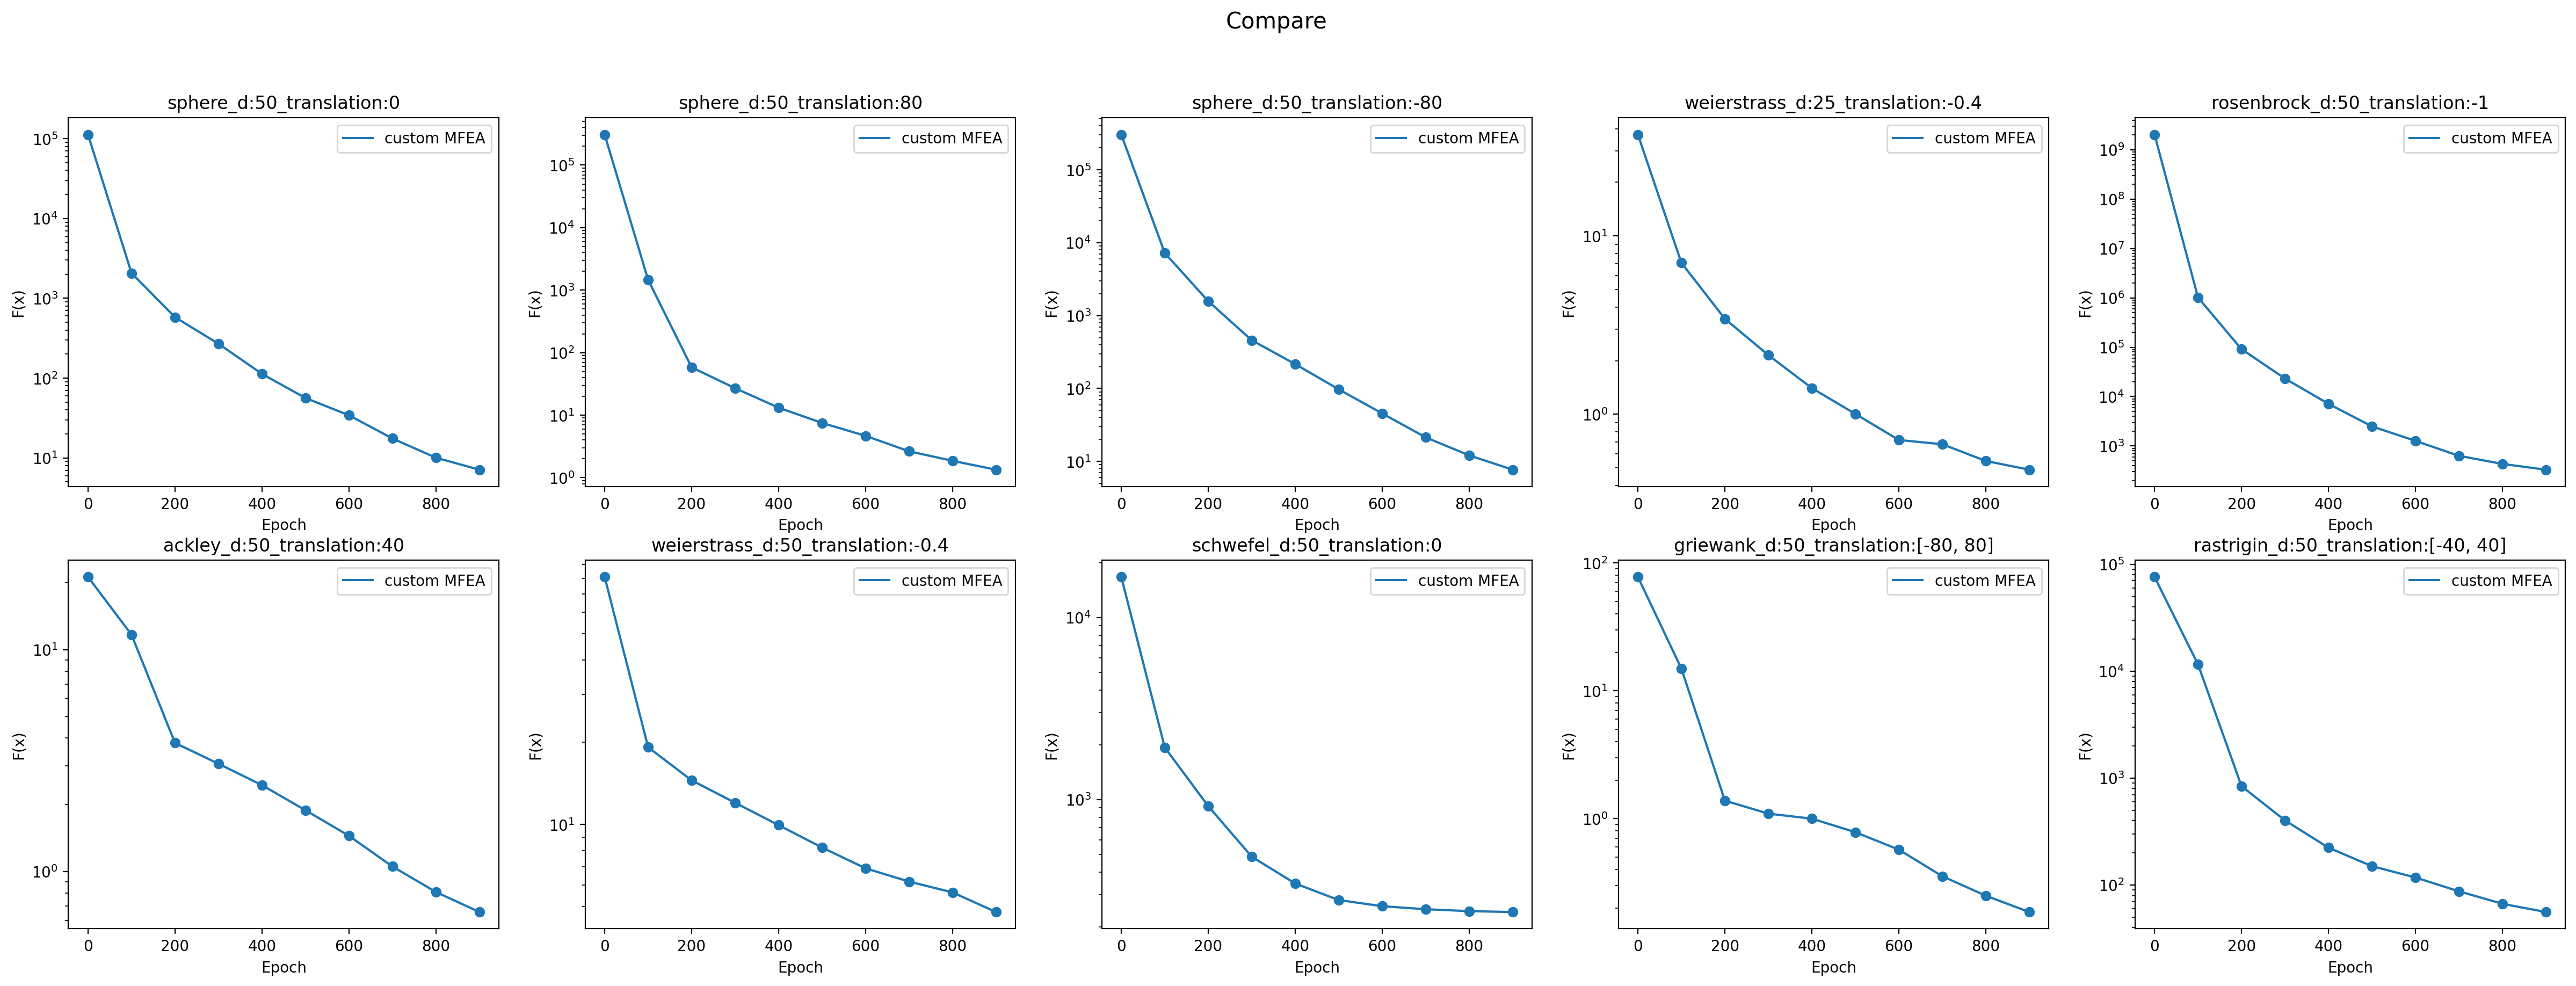

In [ ]:
fig = plt.figure(figsize = (30, 10), dpi= 200)
fig.suptitle("Compare\n", size = 15)
fig.set_facecolor("white")

label_legend = ["custom MFEA"]

for i in range (len(tasks)):
    for idx, sub_his in enumerate([cus_his]): 
        plt.subplot(2, int(len(tasks) / 2), i + 1)

        plt.plot(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i], label= label_legend[idx])
        plt.scatter(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i])
        plt.legend()

    plt.title(tasks[i].name)
    plt.xlabel("Epoch")
    plt.ylabel("F(x)")
    plt.yscale("log")

In [ ]:
get_neg_cus_sol, get_neg_cus_his, get_neg_cus_rmp_his = cus_MFEA(num_epochs= 1000, num_inds_each_task= 100, tasks = tasks,
                        nc = 2, nm = 5, mutation_all_gen= False,
                        sigmoid= 0.1, H = 30, get_neg_Delta= True,
                        one_line=False, num_epochs_printed=10)

Epoch [100/1000], [==>                 ]  10% ,func_val: [2161.4810846227288, 4590.129638036174, 20000.0, 16.206058396166917, 941640.4582927696, 8.284048307082138, 36.63811831536602, 7595.545311896134, 13.500855515530281, 14813.79061011581]

Epoch [200/1000], [====>               ]  20% ,func_val: [642.0159354590928, 110.1899625969247, 225.7085076997133, 4.270253804200678, 105624.97726067038, 4.400730735560373, 11.964043295597634, 493.7362409904381, 1.3841700070135445, 875.002025726734]

Epoch [300/1000], [======>             ]  30% ,func_val: [257.59274365355145, 54.47230098786474, 70.00229515572018, 2.6516633373651217, 20015.771666626188, 3.5784421845028622, 9.031635643328173, 376.75006718010263, 1.0658651588719592, 405.8516773231425]

Epoch [400/1000], [========>           ]  40% ,func_val: [123.68651670413905, 28.856112074486763, 41.630434998299364, 1.8534262529543, 7699.415892780129, 3.00336297844029, 7.888583975839154, 310.51171040521876, 0.9944966797505715, 257.421800965452]

Ep

/tmp/ipykernel_216338/4077550364.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return sol, history_cost, np.array(saved_rmp)


In [ ]:
mfea_his = np.load(file = "./RESULTS/mfea_base_his_CEC17.npy")

sa_his = np.load(file = "./RESULTS/sa_his_CEC17.npy")
sa_rmp_his  = np.load(file = "./RESULTS/sa_rmp_his_CEC17.npy", allow_pickle= True)

lsa_his = np.load(file = "./RESULTS/lsa_his_CEC17.npy")
lsa_rmp_his  = np.load(file = "./RESULTS/lsa_rmp_his_CEC17.npy", allow_pickle= True)

cus_his  = np.load(file = "./RESULTS/custom_his_CEC17.npy")
cus_rmp_his  = np.load(file = "./RESULTS/custon_rmp_his_CEC17.npy", allow_pickle= True)

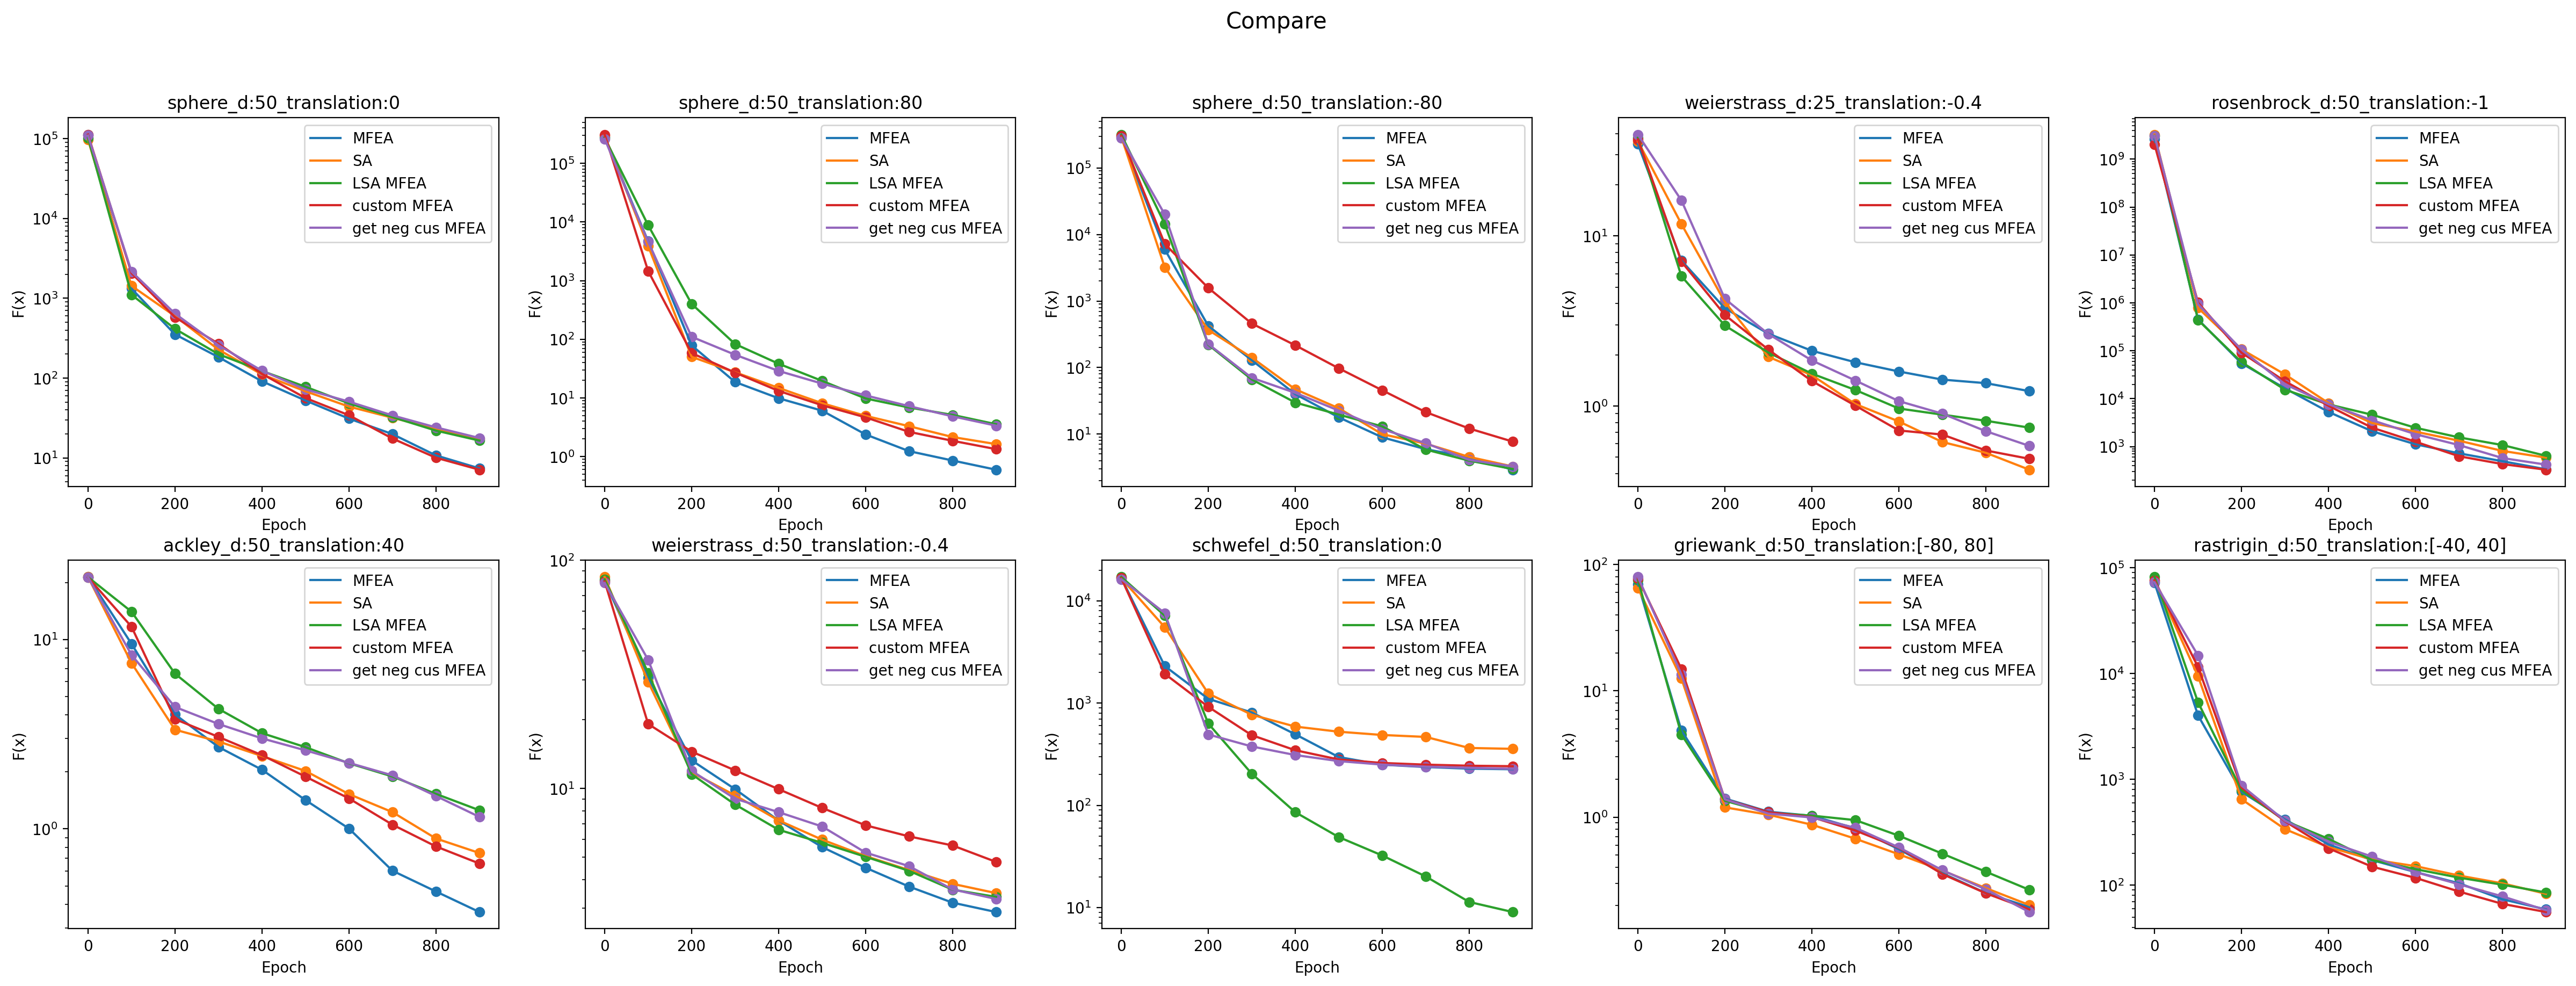

In [ ]:
fig = plt.figure(figsize = (30, 10), dpi= 200)
fig.suptitle("Compare\n", size = 15)
fig.set_facecolor("white")

label_legend = ["MFEA", "SA", "LSA MFEA", "custom MFEA", "get neg cus MFEA"]

for i in range (len(tasks)):
    for idx, sub_his in enumerate([mfea_his, sa_his, lsa_his, cus_his, get_neg_cus_his]): 
        plt.subplot(2, int(len(tasks) / 2), i + 1)

        plt.plot(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i], label= label_legend[idx])
        plt.scatter(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i])
        plt.legend()

    plt.title(tasks[i].name)
    plt.xlabel("Epoch")
    plt.ylabel("F(x)")
    plt.yscale("log")

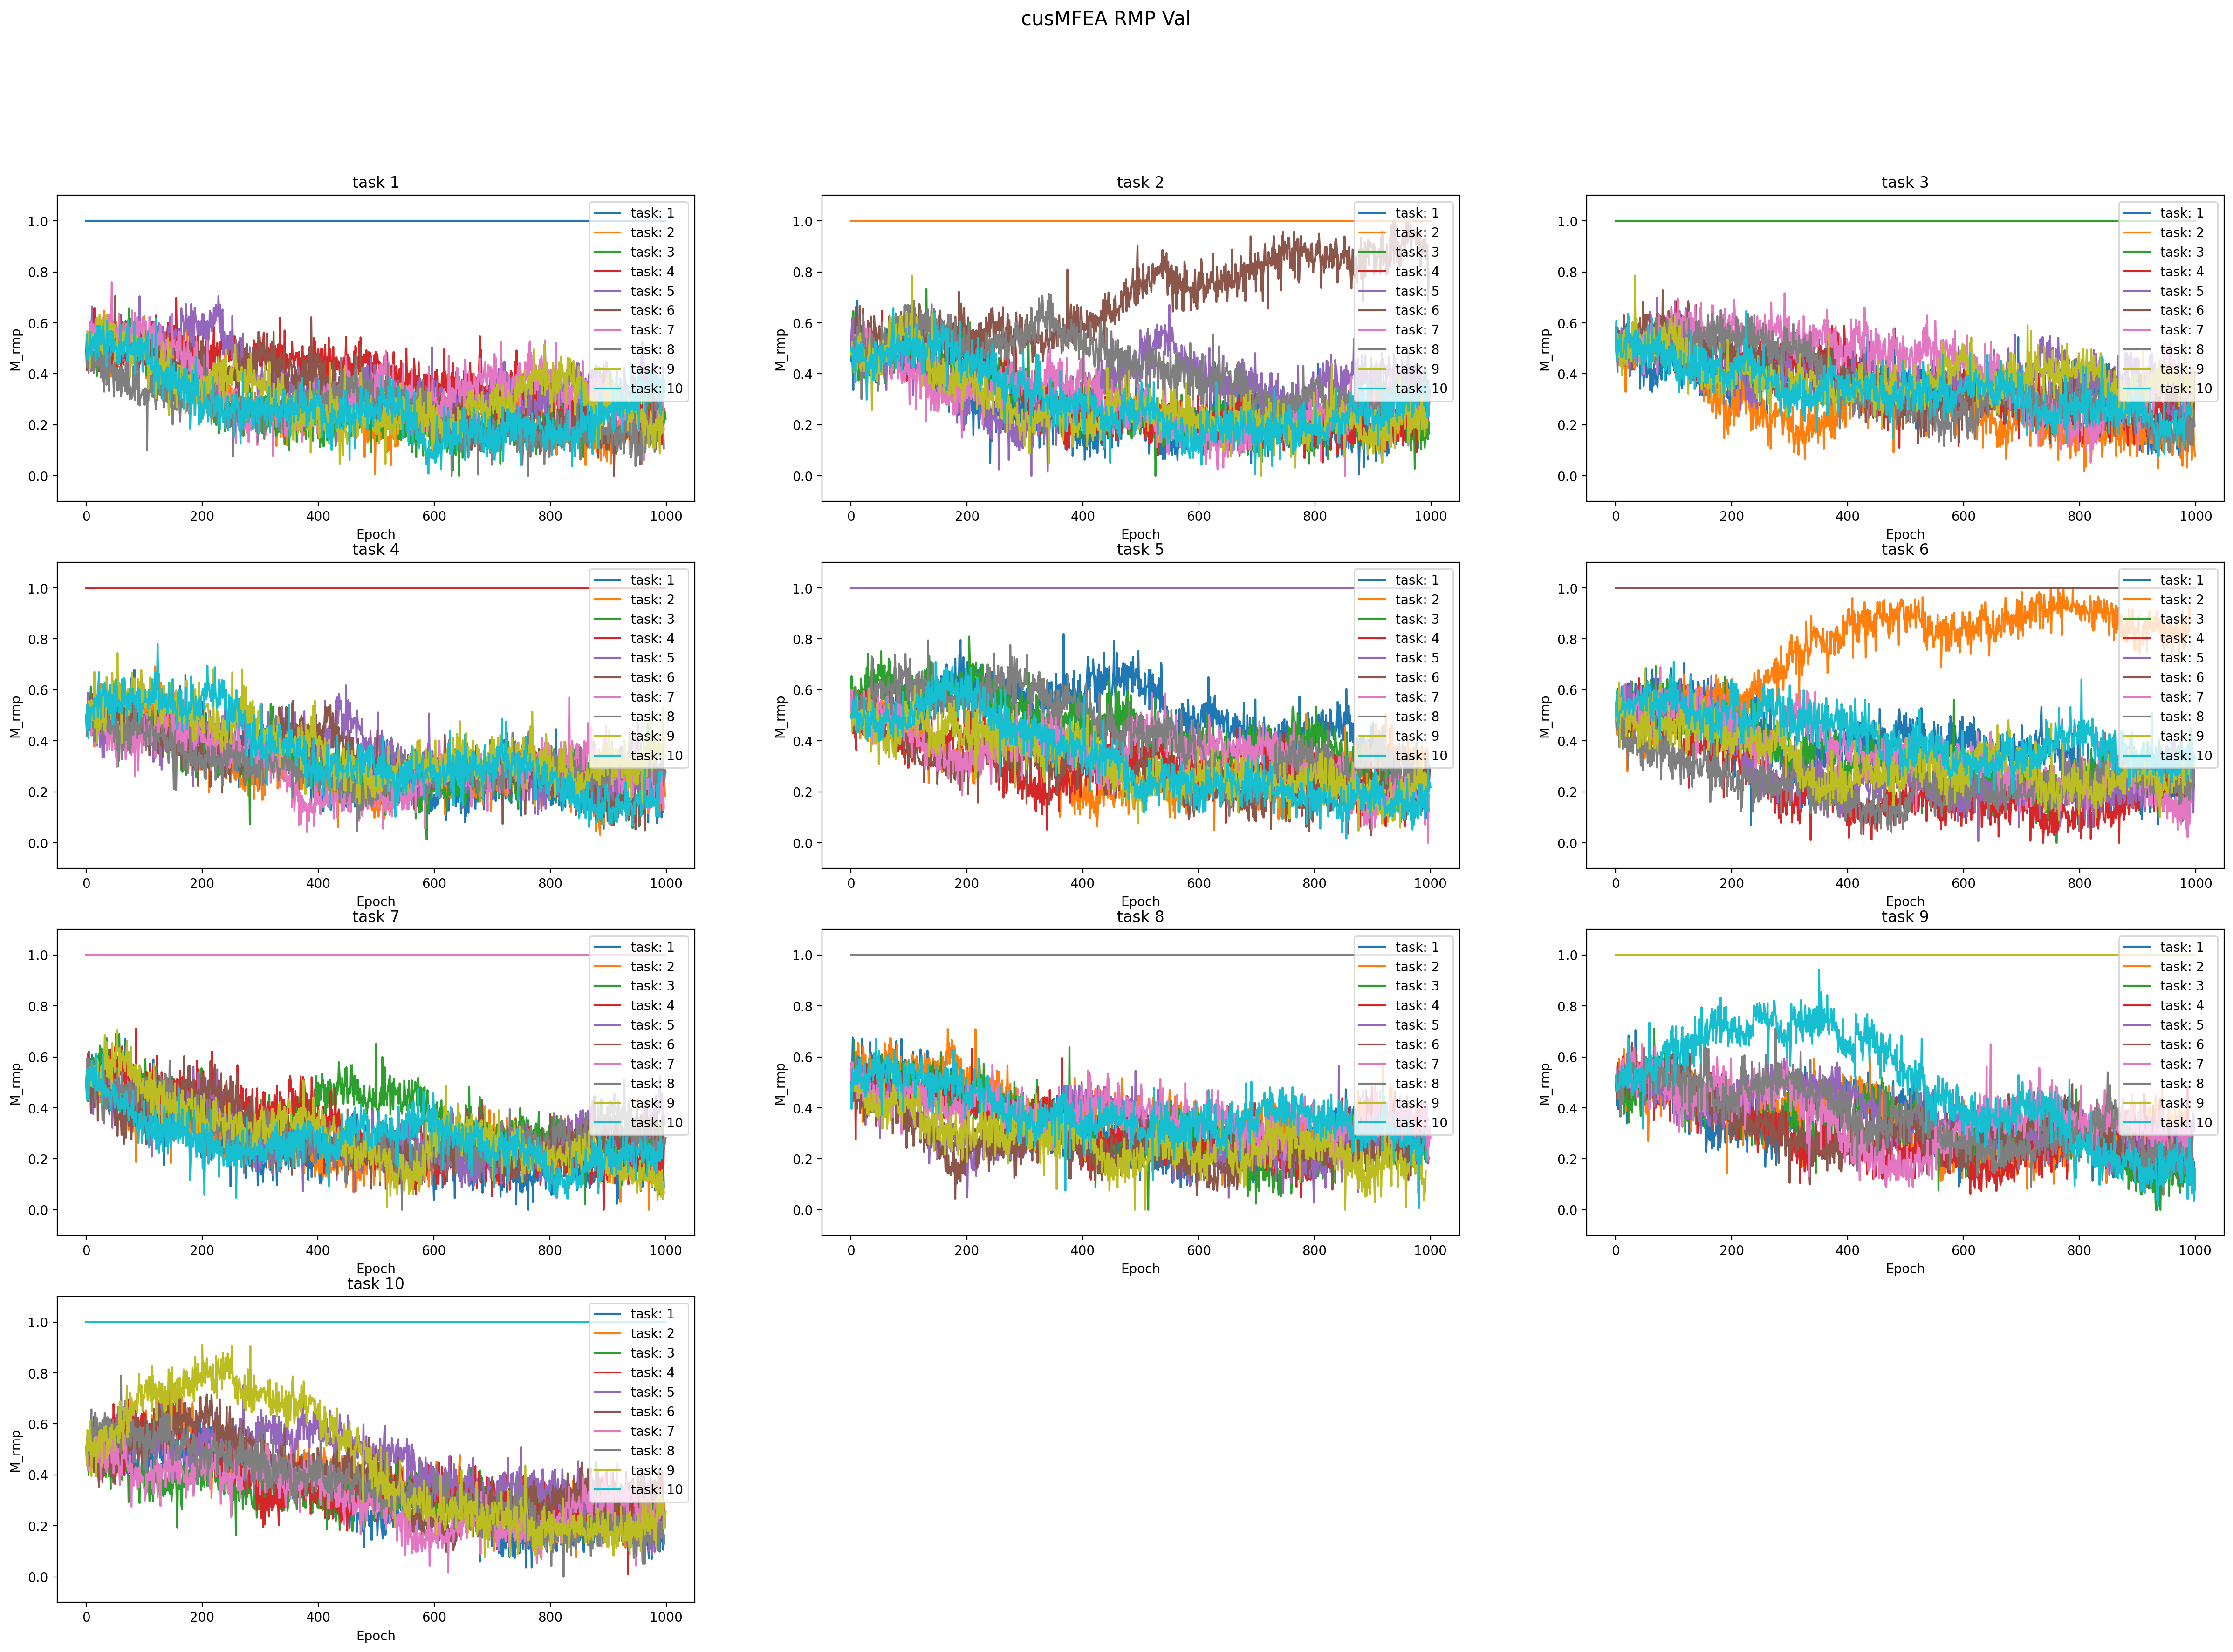

In [ ]:
fig = plt.figure(figsize = (30, 20), dpi= 200)
fig.suptitle("cusMFEA RMP Val\n", size = 15)
fig.set_facecolor("white")

for i in range (len(tasks)):
    for j in range (len(tasks)):
        if i != j: 
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(len(cus_rmp_his[i][j])), np.array(cus_rmp_his[i][j])[:, 0], label= 'task: ' +str(j + 1))
            plt.legend()
        else:
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
            plt.legend()




    plt.title('task ' + str( i + 1))
    plt.xlabel("Epoch")
    plt.ylabel("M_rmp")
    plt.ylim(bottom = -0.1, top = 1.1)


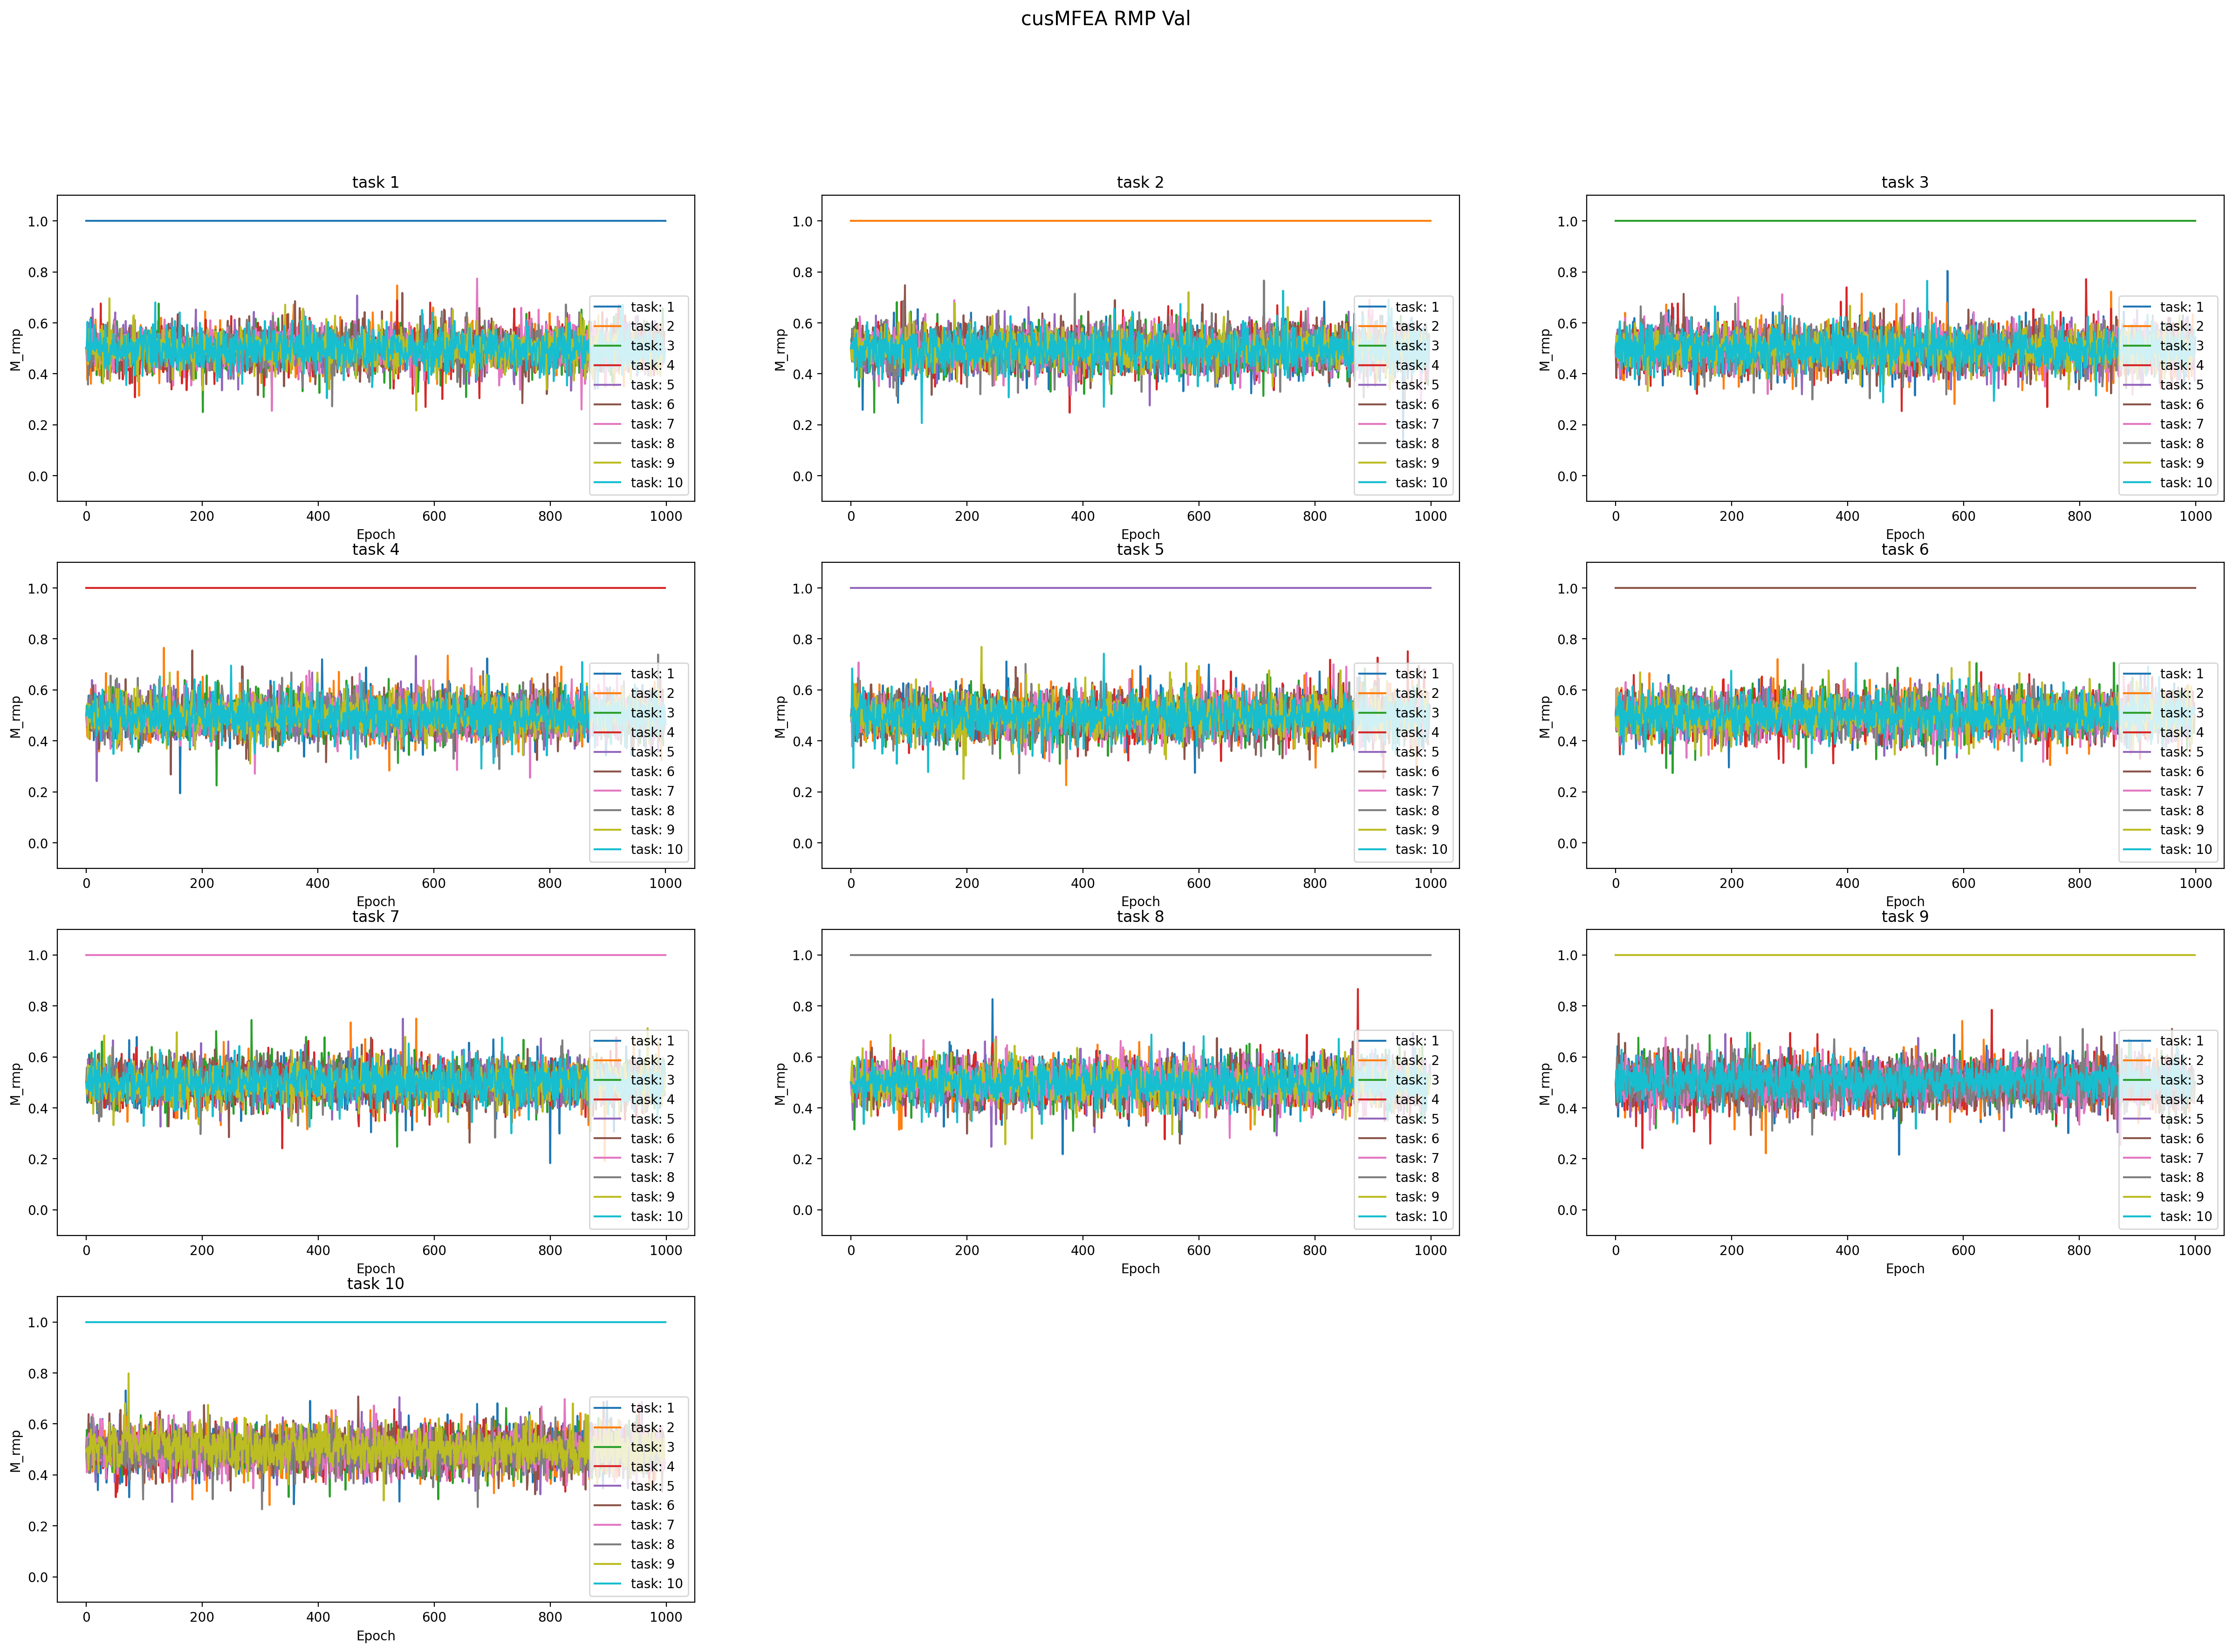

In [ ]:
fig = plt.figure(figsize = (30, 20), dpi= 200)
fig.suptitle("cusMFEA RMP Val\n", size = 15)
fig.set_facecolor("white")

for i in range (len(tasks)):
    for j in range (len(tasks)):
        if i != j: 
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(len(get_neg_cus_rmp_his[i][j])), np.array(get_neg_cus_rmp_his[i][j])[:, 0], label= 'task: ' +str(j + 1))
            plt.legend()
        else:
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
            plt.legend()




    plt.title('task ' + str( i + 1))
    plt.xlabel("Epoch")
    plt.ylabel("M_rmp")
    plt.ylim(bottom = -0.1, top = 1.1)
